In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from pathlib import Path #used for handling path. Instead of using path as strings it converts them into path objects which is usefull in neural networks
from tensorflow.keras.utils import to_categorical #used to convert categorical labels into categorical vectors 
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50

In [2]:
# Creating the Dataset

parent_dir = Path(r"images")

actual_img_paths = [p for child_dir in ['yes','no']
                    if (parent_dir/child_dir).is_dir()
                    for p in (parent_dir/child_dir).glob('*')
                    if not p.name.startswith('.')]

labels = [p.parent.name for p in actual_img_paths]

df = pd.DataFrame({'filepath' : actual_img_paths, 'label' : labels})

In [3]:
df


,filepath,label
0,images\yes\Y1.jpg,yes
1,images\yes\Y10.jpg,yes
2,images\yes\Y100.JPG,yes
3,images\yes\Y101.jpg,yes
4,images\yes\Y102.jpg,yes
...,...,...
248,images\no\No18.jpg,no
249,images\no\No19.jpg,no
250,images\no\No20.jpg,no
251,images\no\No21.jpg,no


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['filepath'], df['label'], test_size = 0.2, random_state = 42)


In [5]:
X_train.size, X_test.size

(202, 51)

In [6]:
#standardizes the input image to 224x224
from tensorflow.keras.applications.resnet50 import preprocess_input
import cv2

def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img = cv2.resize(img, (224,224))
    img = preprocess_input(img) #preprocesses the images (normalizes it so that it is accepted by the model)
    return img

In [7]:
X_train_images = [load_and_preprocess_image(img_path) for img_path in X_train]

X_train_images = np.array([img for img in X_train_images if img is not None]) # to remove any failed loads

X_test_images = [load_and_preprocess_image(img_path) for img_path in X_test]

X_test_images = np.array([img for img in X_test_images if img is not None])


In [8]:
#one-hot encode the labels for format compatibility
le = LabelEncoder()
y_train_encoded = le.fit_transform(Y_train)
y_test_encoded = le.fit_transform(Y_test)

X_train_shuffled, Y_train_shuffled = shuffle(X_train_images, y_train_encoded, random_state = 42)

y_train_shuffled_encoded = to_categorical(Y_train_shuffled)
y_test_encoded = to_categorical(y_test_encoded)

In [9]:
#data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

demo_datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True,
    vertical_flip = False,
    fill_mode = 'nearest',
    brightness_range = [0.8, 1.2],
    channel_shift_range = 20
)

In [10]:
demo_datagen.fit(X_train_shuffled)

In [11]:
#Model building
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
#include_top = False This means that the fully connected layers at the top of the model wont be included. instead only the convolutional layers are loaded.
base_model.trainable = False #base_model weights are frozen. The weights of the base_model will not be updated during training

input_layer = Input(
    shape = (224,224,3)
)

x = base_model(input_layer, training = False) #training = False tells the model to act as if it is making predictions instead of learning. Batch normalization in inference doesnt use the current batch, it uses the average values it learned during training to normalize the data. this ensures that the model makes consistent predictions, even with small batches. For Dropout layers, during inference. It doesnt drop any neurons. It uses the full network for predictions.

x = Flatten()(x) #converts 2D or 3D array into a !d vector which is required as an input to the dense layers

x = Dense(224, activation='relu')(x) #is used in the hidden layers to introduce non-linearity.
x = Dropout(0.5)(x)
output_layer = Dense(2, activation='softmax')(x) #is used to convert the vector values into probabilities for the final layer

model = Model(inputs = input_layer, outputs = output_layer)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())




94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 59s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 224)            │    22,479,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,067,234 (175.73 MB)

 Trainable params: 22,479,522 (85.75 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


In [12]:
history = model.fit(
    demo_datagen.flow(X_train_shuffled, y_train_shuffled_encoded, batch_size = 32),
    epochs = 15,
    validation_data = (X_test_images, y_test_encoded)
)

#.flow takes in your training data and returns a generator that yields batches of images and labels during training.

Epoch 1/15


c:\Users\kenneth\OneDrive\Desktop\Brain Tumour Detection\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4830 - loss: 25.4791 - val_accuracy: 0.8824 - val_loss: 3.3566
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6428 - loss: 5.2134 - val_accuracy: 0.8431 - val_loss: 1.5409
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8200 - loss: 1.7174 - val_accuracy: 0.9020 - val_loss: 0.4610
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8219 - loss: 0.5570 - val_accuracy: 0.8431 - val_loss: 0.4361
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8695 - loss: 0.3868 - val_accuracy: 0.8431 - val_loss: 0.4918
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7469 - loss: 0.4612 - val_accuracy: 0.8627 - val_loss: 0.4081
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8323 - loss: 0.3855 - val_accuracy: 0.8431 - val_loss: 0.4239
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8566 - loss: 0.3734 - val_accuracy: 0.8627 - val_loss: 0.3786
Epoch 9/15
7/7 ━━━

In [13]:
#model evalution
y_pred = model.predict(X_test_images)
y_pred_classes = np.argmax(y_pred, axis = 1) #will find the index of the maximum value along the rows which corresponds to the predicted class.
y_true = np.argmax(y_test_encoded, axis = 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


In [14]:
print("Classification Report:\n", classification_report(y_true, y_pred_classes))
print("Classificaiton Matrix:\n", confusion_matrix(y_true, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89        24
           1       0.89      0.93      0.91        27

    accuracy                           0.90        51
   macro avg       0.90      0.90      0.90        51
weighted avg       0.90      0.90      0.90        51

Classificaiton Matrix:
 [[21  3]
 [ 2 25]]


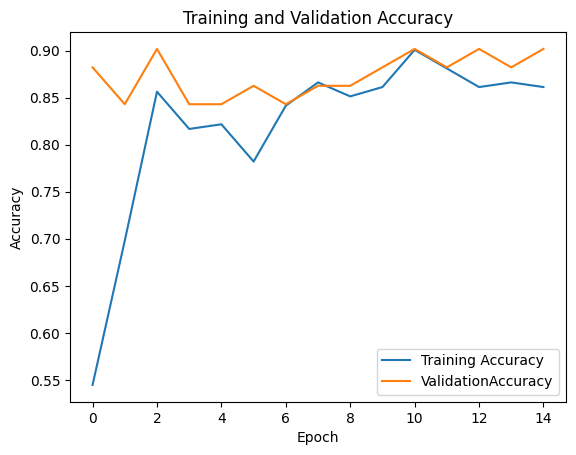

In [15]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='ValidationAccuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()